# Frame the Problem

### Story
The United Kingdom government wants to devote a large portion of funding towards suprressing vehicular accidents. Before they go through with this proposed funding, they want to identify trends in the accident reports to find spots of high accidental occurence. The funding will be used to fix the roads and/or create new, safer road designs.

1. Define the objective in business terms. 
    - Utilizing the United Kingdom vehicle related accidents dataset, we want to identify causes of accidents for different areas in the UK and determine what spots should the funding be focused to.
2. How will your solution be used? 
    - Hopefully, by figuring out the locations of high accidents and also determine their causes, we will able to rationalize the funding.
3. What are the current solutions/workarounds (if any)? 
    - None
4. How should you frame this problem (supervised/unsupervised, online/offline, ...)? 
    - This will be a supervised, classification offline learning problem.
5. How should performance be measured? Is the performance measure aligned with the business objective?
    - To not waste fundings, we would want to be as accurate as possible as this proposal was created in the intent to save lives. Therefore we would want to use precision.
6. What would be the minimum performance needed to reach the business objective? 
    - Because we want to be extremely accurate, we want to aim for the best performance possible. Based on the score will determine whether or not the funding should be dispersed.
7. What are comparable problems? Can you reuse experience or tools?
    - A similar problem would be the bike sharing problem where there was a similar design in the "hot spots" and it being a supervised classification itself.
8. Is human expertise available?
    - No
9. How would you solve the problem manually?
    - I would try and find trends of accidents at specific spots. Perhaps this spot at this time is more prone to there being accidents, maybe this spot has a bad blind spot for vehicles causing more civilian death. I would leave out consumer related information such as the type of vehicles, however still would check to see if specific cause more accidents at certain spots (maybe super cars on highways?). I would also try and see trends in the person information, perhaps deduce whether new laws should be constructed for older drivers to be reexamined. I would also leave out unnecessary data like resulting police force.
10.  List the assumptions you (or others) have made so far. Verify assumptions if possible.
    - I assume that weather would be a cause for higher deaths and also time frames for rush hour. I also assume living types such as rural vs city would be much different. Highways would have much more severe accidents.



# Get the Data

In [2]:
import numpy as np
import scipy.sparse
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MultiLabelBinarizer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:
def load_data():
    """
    Loads the data from the CSV files.
    """
    
    accidents = pd.read_csv('Accidents0514.csv')
    casualties = pd.read_csv('Casualties0514.csv')
    vehicles = pd.read_csv('Vehicles0514.csv')
    return accidents, casualties, vehicles

In [4]:
accidents, casualties, vehicles = load_data()

/var/folders/r0/j9fj5kfx7_jgn2n0zrsdzdxc0000gp/T/ipykernel_78362/3544293404.py:1: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  accidents, casualties, vehicles = load_data()


In [5]:
"""
The accident file provide detailed about the circumstances of an accident from 2005 to 2014 such as weather, location lat/long, area type, road type,date, time, day of week and much more…
The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.
All the data variables are coded rather than containing textual strings.
The lookup tables are available in the xlsx file "Additional resources" section towards the bottom of the table.
"""

# drop irrelevant features
accidents.drop('LSOA_of_Accident_Location', axis=1, inplace=True)
accidents.drop('Did_Police_Officer_Attend_Scene_of_Accident', axis=1, inplace=True)
accidents.drop('Carriageway_Hazards', axis=1, inplace=True)
accidents.drop('Location_Easting_OSGR', axis=1, inplace=True)
accidents.drop('Location_Northing_OSGR', axis=1, inplace=True)
accidents.drop('Police_Force', axis=1, inplace=True)
accidents.drop('Local_Authority_(District)', axis=1, inplace=True)
accidents.drop('Local_Authority_(Highway)', axis=1, inplace=True)
accidents.drop('1st_Road_Class', axis=1, inplace=True)
accidents.drop('1st_Road_Number', axis=1, inplace=True)
accidents.drop('2nd_Road_Class', axis=1, inplace=True)
accidents.drop('2nd_Road_Number', axis=1, inplace=True)
accidents.drop('Pedestrian_Crossing-Human_Control', axis=1, inplace=True)
accidents.drop('Pedestrian_Crossing-Physical_Facilities', axis=1, inplace=True)
accidents.drop('Special_Conditions_at_Site', axis=1, inplace=True)
accidents.drop('Number_of_Vehicles', axis=1, inplace=True)
accidents.drop('Number_of_Casualties', axis=1, inplace=True)



In [6]:
"""
The casualties file provide detailed about the circumstances of an accident from 2005 to 2014 such as casualty age, sex, casualty severity, casualty social class, casualty type and much more…
The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.
All the data variables are coded rather than containing textual strings.
The lookup tables are available in the xlsx file "Additional resources" section towards the bottom of the table
"""
casualties.drop('Age_Band_of_Casualty', axis=1, inplace=True)

casualties

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
0,200501BS00001,1,1,3,1,37,2,1,1,0,0,-1,0,1
1,200501BS00002,1,1,2,1,37,3,0,0,0,4,-1,11,1
2,200501BS00003,2,1,1,1,62,3,0,0,0,0,-1,9,1
3,200501BS00004,1,1,3,1,30,3,5,2,0,0,-1,0,1
4,200501BS00005,1,1,1,1,49,3,0,0,0,0,-1,3,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2216715,2014984137714,1,1,2,2,16,3,0,0,2,0,0,9,1
2216716,2014984138414,1,1,1,1,27,3,0,0,0,0,0,9,1
2216717,2014984138414,2,2,1,1,44,2,0,0,0,0,0,19,1
2216718,2014984139614,1,2,2,1,61,3,0,0,0,4,0,11,2


In [7]:
"""
The vehicles file provide detailed about the circumstances of an accident from 2005 to 2014 such as vehicle type, age of driver, sex of driver, age of vehicle, engine type, journey purpose and much more…
The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.
All the data variables are coded rather than containing textual strings.
The lookup tables are available in the xlsx file "Additional resources" section towards the bottom of the table.
"""
vehicles.drop('Engine_Capacity_(CC)', axis=1, inplace=True)
vehicles.drop('Propulsion_Code', axis=1, inplace=True)
vehicles.drop('Driver_IMD_Decile', axis=1, inplace=True)
vehicles.drop('Towing_and_Articulation', axis=1, inplace=True)
vehicles.drop('Journey_Purpose_of_Driver', axis=1, inplace=True)
vehicles.drop('Vehicle_Location-Restricted_Lane', axis=1, inplace=True)
vehicles.drop('Hit_Object_in_Carriageway', axis=1, inplace=True)
vehicles.drop('Vehicle_Leaving_Carriageway', axis=1, inplace=True)

vehicles

,Accident_Index,Vehicle_Reference,Vehicle_Type,Vehicle_Manoeuvre,Junction_Location,Skidding_and_Overturning,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type
0,200501BS00001,1,9,18,0,0,0,1,1,2,74,10,-1,1
1,200501BS00002,1,11,4,3,0,0,4,1,1,42,7,3,-1
2,200501BS00003,1,11,17,0,0,0,4,1,1,35,6,5,1
3,200501BS00003,2,9,2,0,0,0,3,1,1,62,9,6,1
4,200501BS00004,1,9,18,0,0,0,1,1,2,49,8,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004420,2014984138414,1,9,5,6,0,0,3,1,1,27,6,12,1
3004421,2014984138414,2,19,18,1,1,11,1,1,1,44,7,4,1
3004422,2014984138414,3,9,18,2,1,0,3,1,1,73,10,-1,3
3004423,2014984139614,1,11,9,8,0,0,3,1,1,40,7,4,3


In [8]:
# Create a combined df before we remove features
combined = pd.merge(accidents, casualties, on='Accident_Index')
combined = pd.merge(combined, vehicles, on='Accident_Index')

In [9]:
"""
The lookup file contain all the information to map the coded variables with their textual strings

"""

road_accident_guide = pd.ExcelFile(r'Road-Accident-Safety-Data-Guide.xls')

In [10]:
road_accident_guide.sheet_names

['Introduction',
 'Export Variables',
 'Police Force',
 'Accident Severity',
 'Day of Week',
 'Local Authority (District)',
 'Local Authority (Highway)',
 '1st Road Class',
 'Road Type',
 'Junction Detail',
 'Junction Control',
 '2nd Road Class',
 'Ped Cross - Human',
 'Ped Cross - Physical',
 'Light Conditions',
 'Weather',
 'Road Surface',
 'Special Conditions at Site',
 'Carriageway Hazards',
 'Urban Rural',
 'Police Officer Attend',
 'Vehicle Type',
 'Towing and Articulation',
 'Vehicle Manoeuvre',
 'Vehicle Location',
 'Junction Location',
 'Skidding and Overturning',
 'Hit Object in Carriageway',
 'Veh Leaving Carriageway',
 'Hit Object Off Carriageway',
 '1st Point of Impact',
 'Was Vehicle Left Hand Drive',
 'Journey Purpose',
 'Sex of Driver',
 'Age Band',
 'Vehicle Propulsion Code',
 'Casualty Class',
 'Sex of Casualty',
 'Age of Casualty',
 'Casualty Severity',
 'Ped Location',
 'Ped Movement',
 'Car Passenger',
 'Bus Passenger',
 'Ped Road Maintenance Worker',
 'Casualty Ty

In [11]:

# turn combined time object into float
combined['Time_Num'] = combined['Time'].astype(str)
combined['Time_Num'] = combined['Time_Num'].str.replace(':', '')
combined['Time_Num'] = combined['Time_Num'].astype(float)

In [12]:
# column for hour and column for every ten minutes
combined['Hour'] = combined['Time_Num'] // 100
combined['Minute'] = combined['Time_Num'] % 100

In [13]:
# convert data to datetimelike values
combined['Date'] = pd.to_datetime(combined['Date'])

# column for day of week
combined['Day_of_Week'] = combined['Date'].dt.dayofweek

# # column for month
combined['Month'] = combined['Date'].dt.month

# # column for year
combined['Year'] = combined['Date'].dt.year

# # column for month and year
combined['Month_Year'] = combined['Date'].dt.strftime('%m%Y')

# # column for day of week and month
combined['Day_of_Week_Month'] = combined['Date'].dt.strftime('%w%m')

# # column for time of day and day of week
combined['Time_of_Day_Day_of_Week'] = combined['Date'].dt.strftime('%H%w')

In [14]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4287593 entries, 0 to 4287592
Data columns (total 51 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   Accident_Index                      object        
 1   Longitude                           float64       
 2   Latitude                            float64       
 3   Accident_Severity                   int64         
 4   Number_of_Vehicles                  int64         
 5   Number_of_Casualties                int64         
 6   Date                                datetime64[ns]
 7   Day_of_Week                         int64         
 8   Time                                object        
 9   Road_Type                           int64         
 10  Speed_limit                         int64         
 11  Junction_Detail                     int64         
 12  Junction_Control                    int64         
 13  Light_Conditions                    int64 

In [15]:
combined_trained, combined_test = train_test_split(combined, test_size=0.15, random_state=42)

# Explore the Data

In [16]:
combined_samples = combined_trained.sample(n=100000, random_state=42)


In [17]:
# make a scatter matrix of all the features in combined_samples
combined_samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 3732112 to 2158892
Data columns (total 51 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Accident_Index                      100000 non-null  object        
 1   Longitude                           99991 non-null   float64       
 2   Latitude                            99991 non-null   float64       
 3   Accident_Severity                   100000 non-null  int64         
 4   Number_of_Vehicles                  100000 non-null  int64         
 5   Number_of_Casualties                100000 non-null  int64         
 6   Date                                100000 non-null  datetime64[ns]
 7   Day_of_Week                         100000 non-null  int64         
 8   Time                                99992 non-null   object        
 9   Road_Type                           100000 non-null  int64         
 10  S

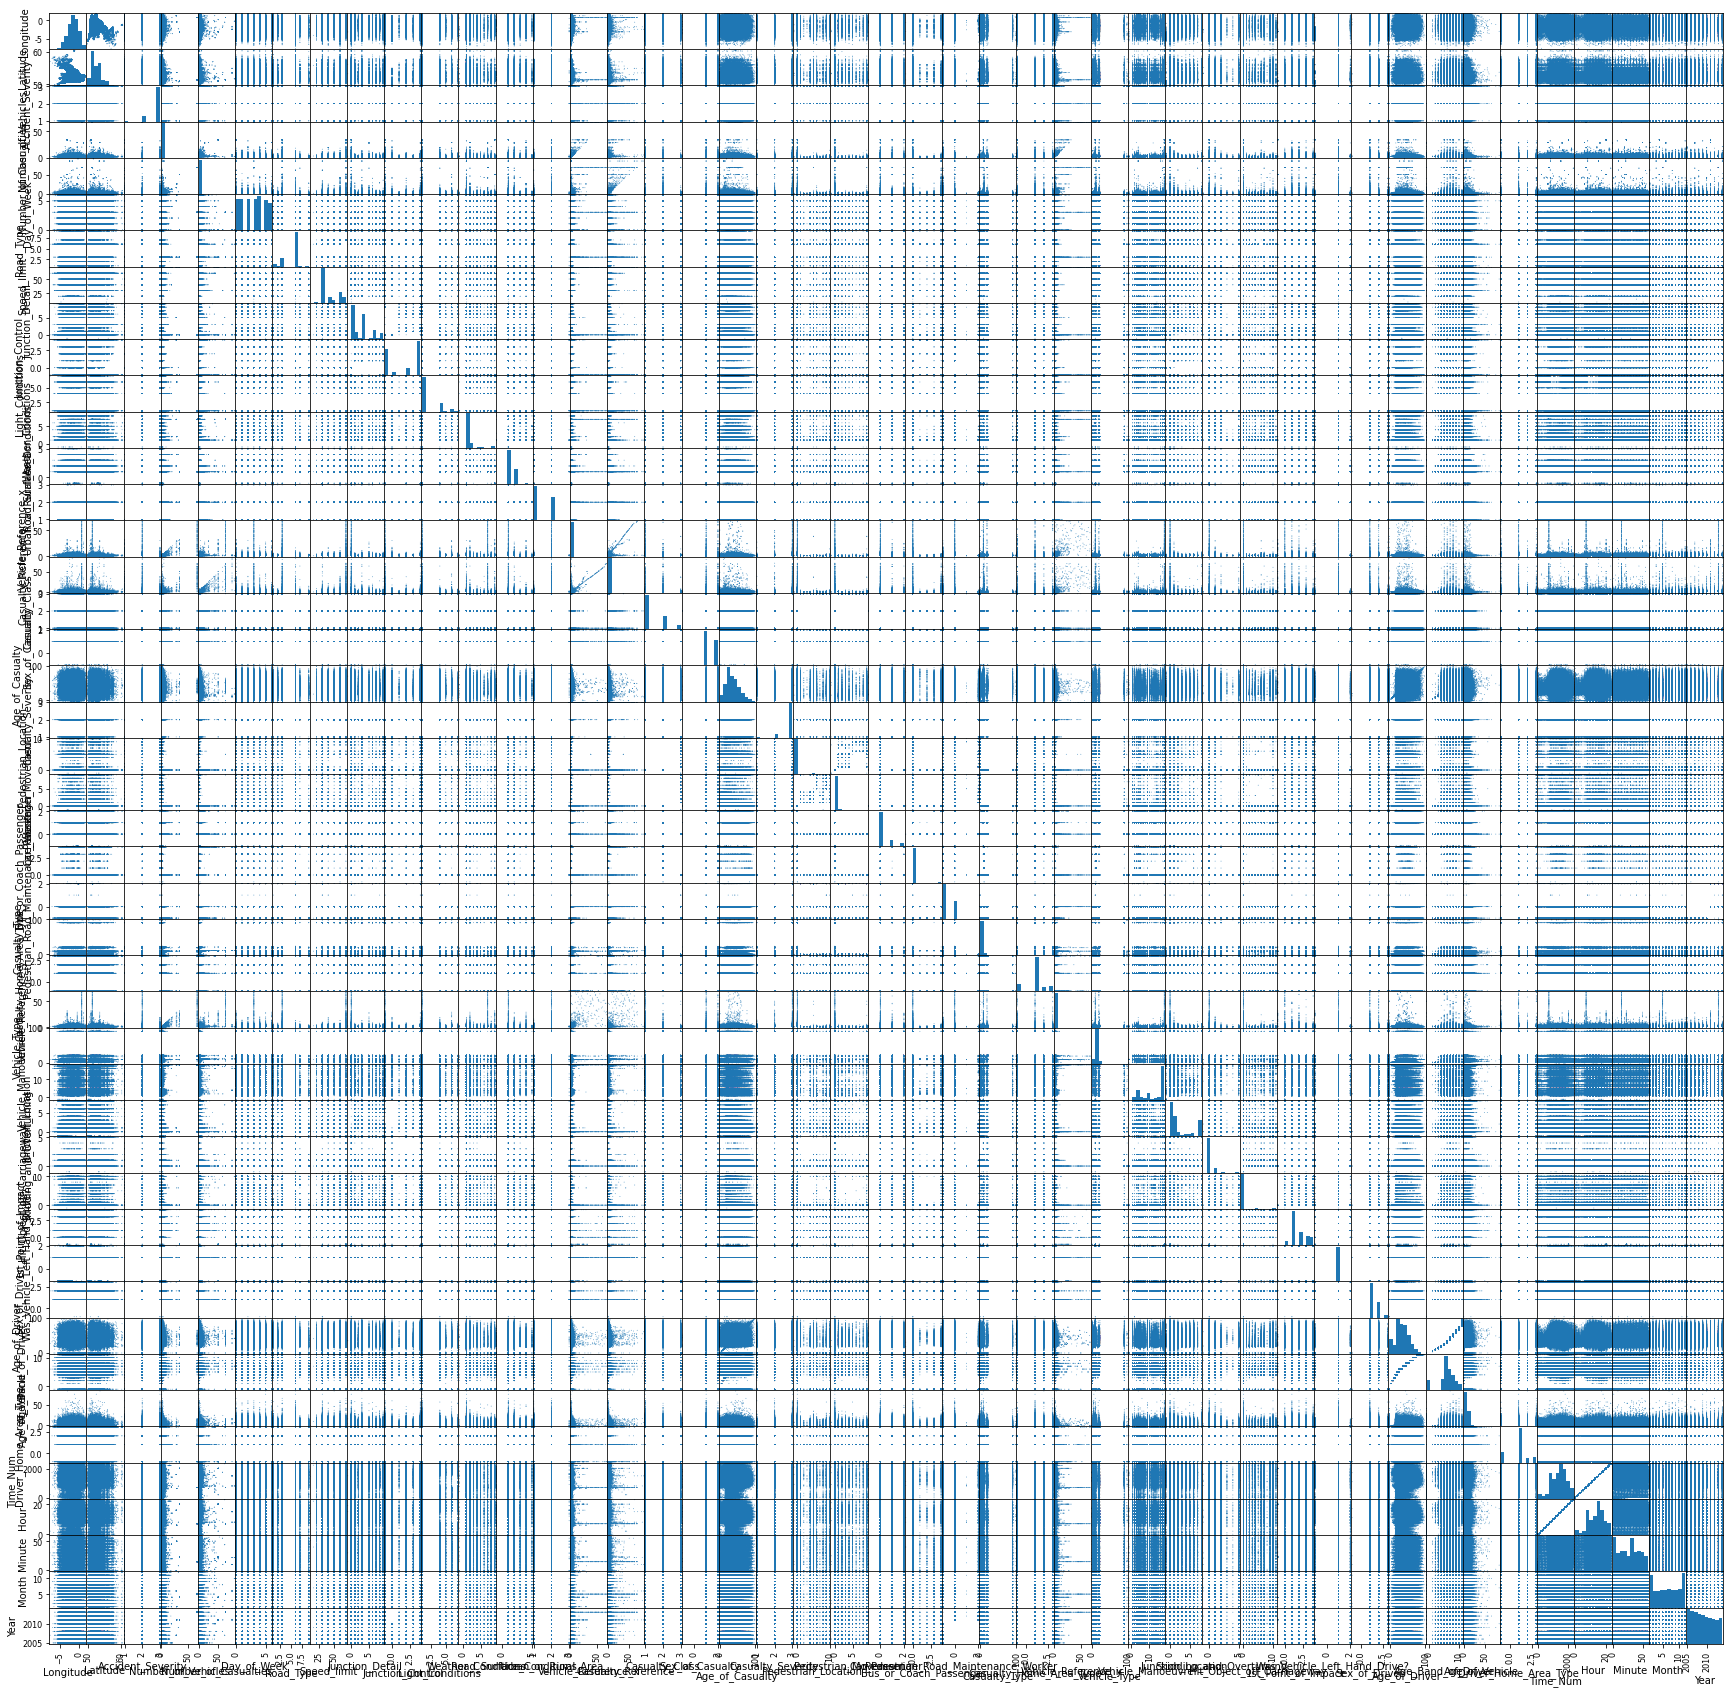

In [178]:
# make a scatter plot of all the features in combined_samples
pd.plotting.scatter_matrix(combined_samples, figsize=(30, 30), s=3, alpha=0.8);

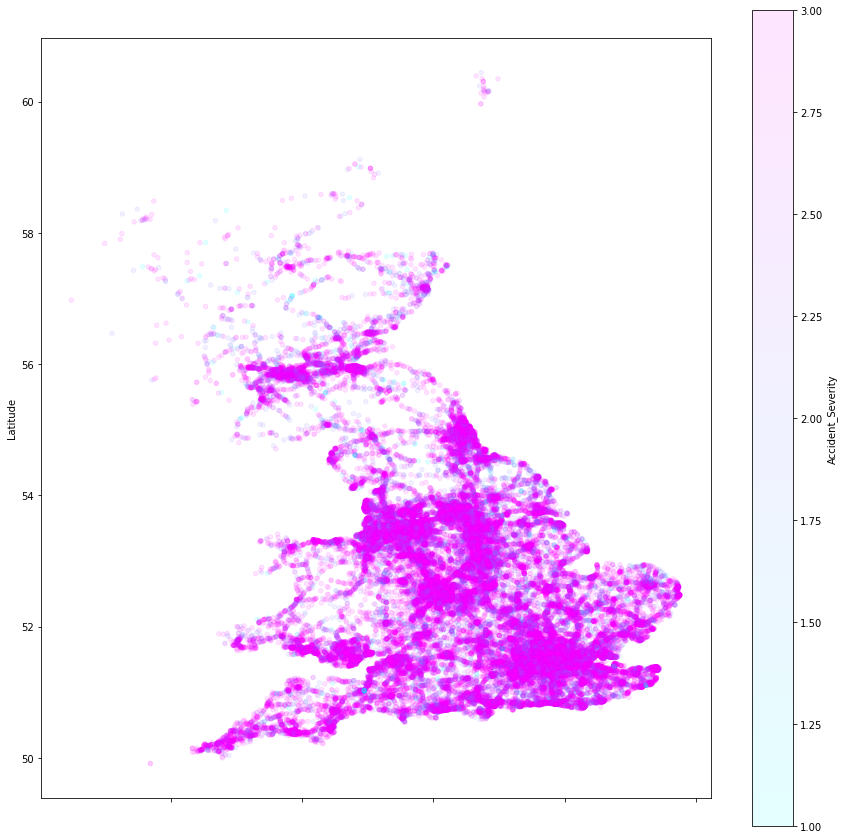

In [25]:
# View the geographical data based on accident severity (lightblue - high, blurple - mid, purple - low)
# This graph highlights where the low accidents occur
combined_samples.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1, c='Accident_Severity' , cmap='cool', figsize=(15,15));
plt.gca().set_aspect('equal')

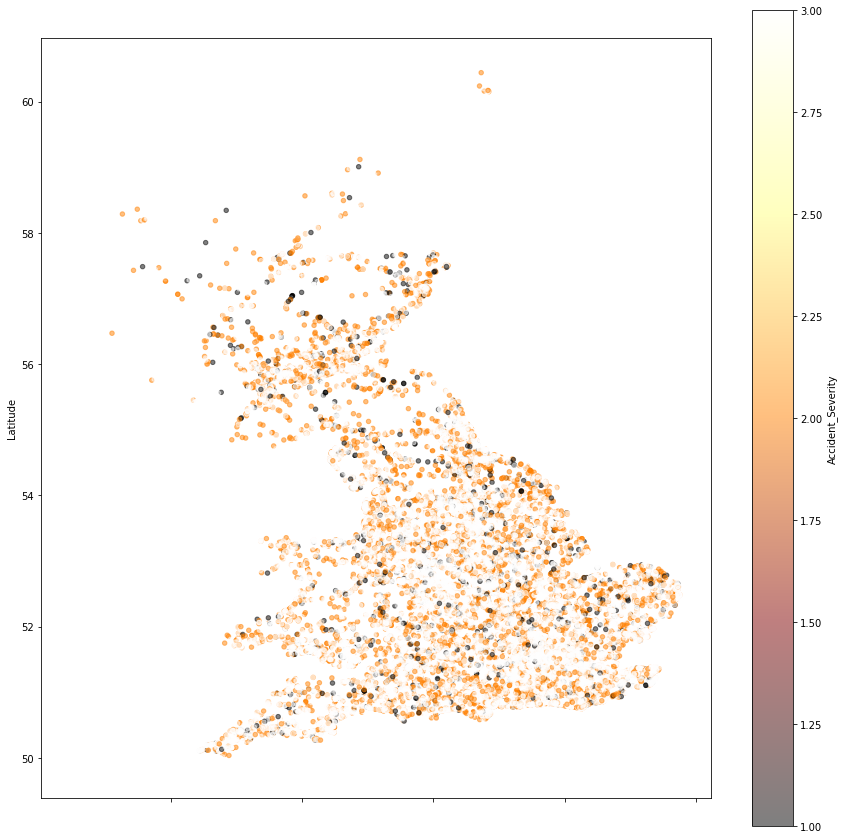

In [19]:
# View the geographical data based on accident severity (black high, orange - mid, white - low)
# This graph highlights where the high accidents occur (denoted by black dots)
# High accidents aren't as common as low accidents, so it's a good idea to focus on the high accidents
combined_samples.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.5, c='Accident_Severity' , cmap='afmhot', figsize=(15,15));
plt.gca().set_aspect('equal')

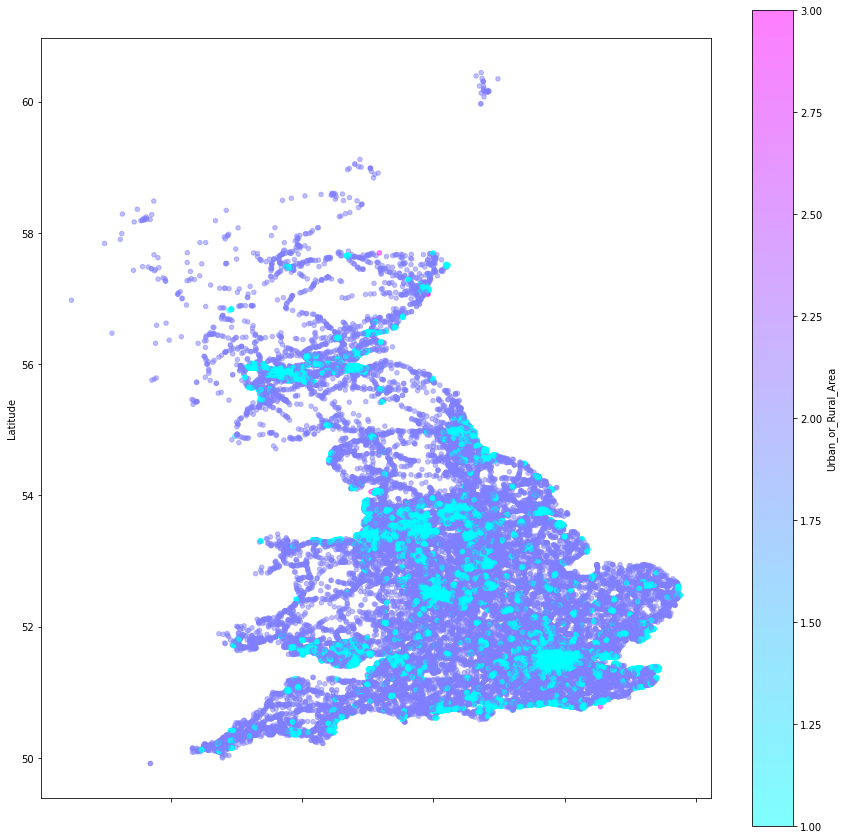

In [20]:
# View the geographical data based on Area type of the accident (light blue - urban, blueple - rural, purple - unallocated)
# This graph highlights where the urban accidents occur
# Concentration of low accidents occur in the urban areas
combined_samples.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.5, c='Urban_or_Rural_Area' , cmap='cool', figsize=(15,15));
plt.gca().set_aspect('equal')

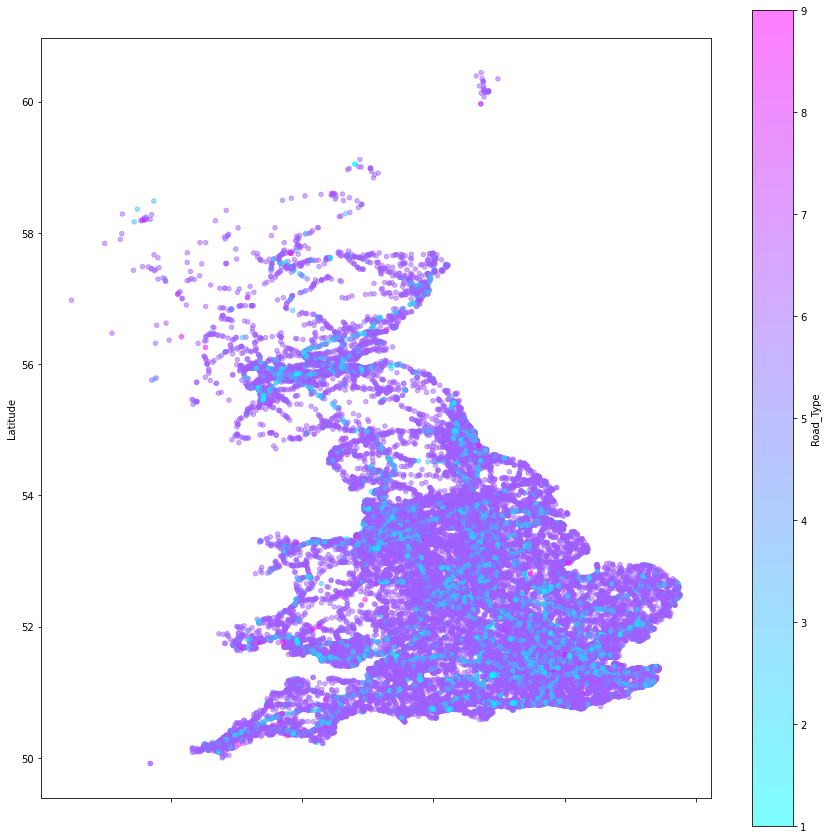

In [32]:
# View the geographical data based on Area type of the accident (light blue - urban, blueple - rural, purple - unallocated)
# This graph highlights where the urban accidents occur
# Concentration of low accidents occur in the urban areas
combined_samples.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.5, c='Road_Type' , cmap='cool', figsize=(15,15));
plt.gca().set_aspect('equal')

KeyError: 'Local_Authority_(District)'

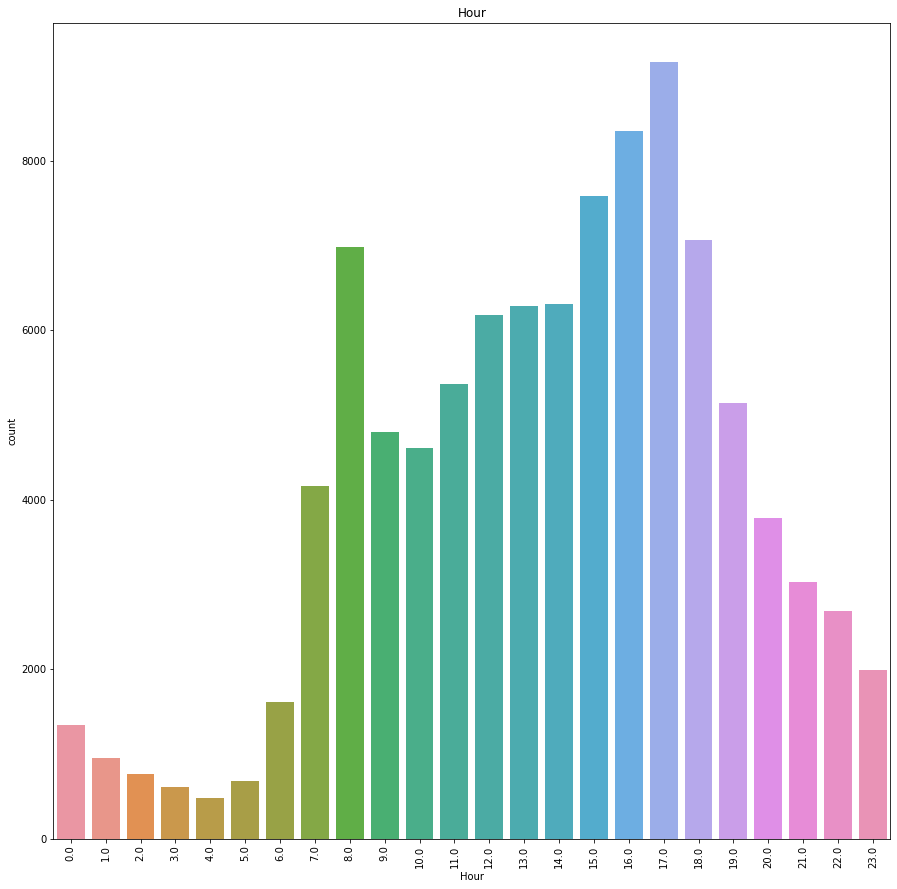

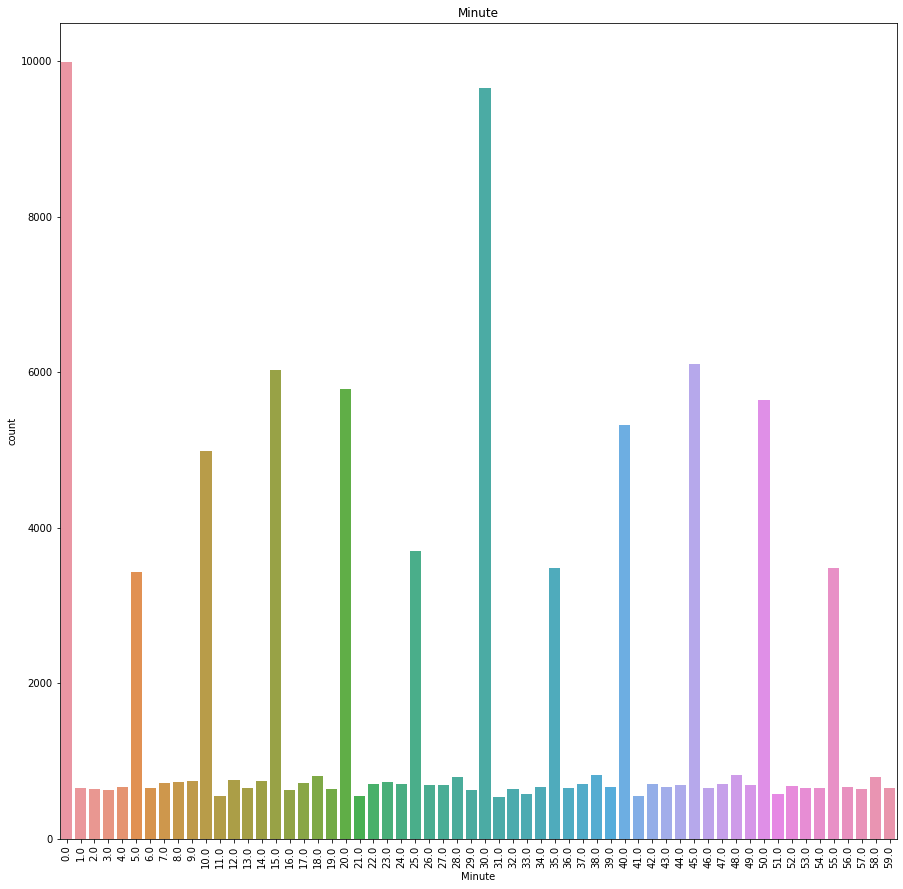

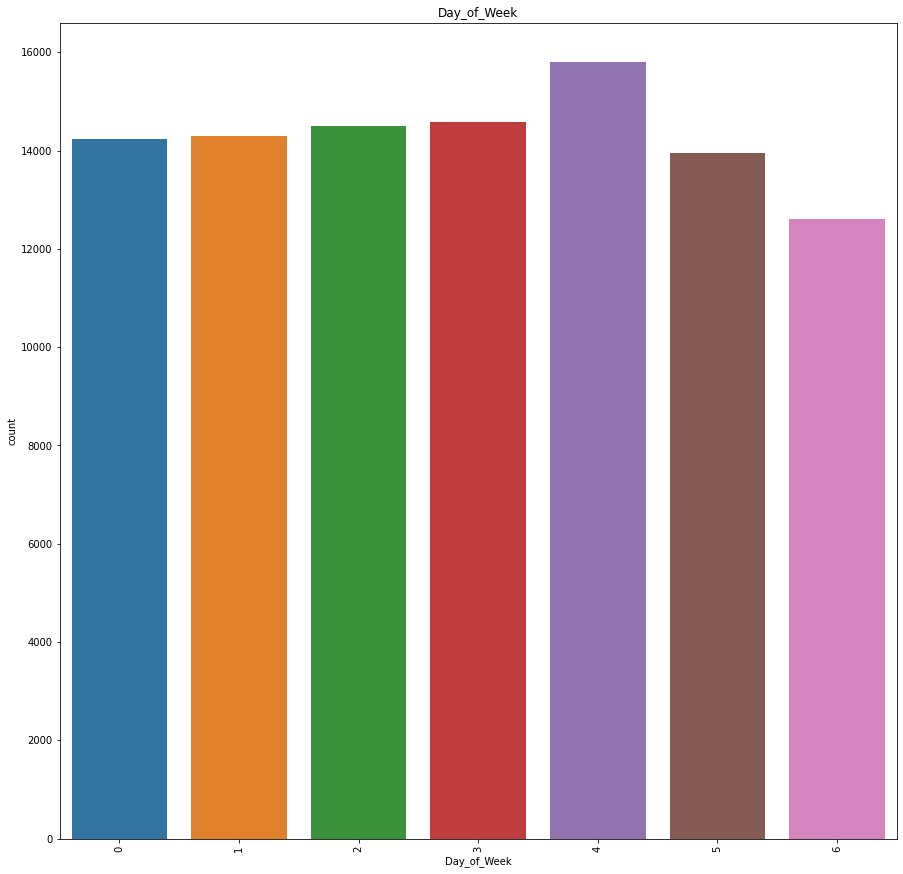

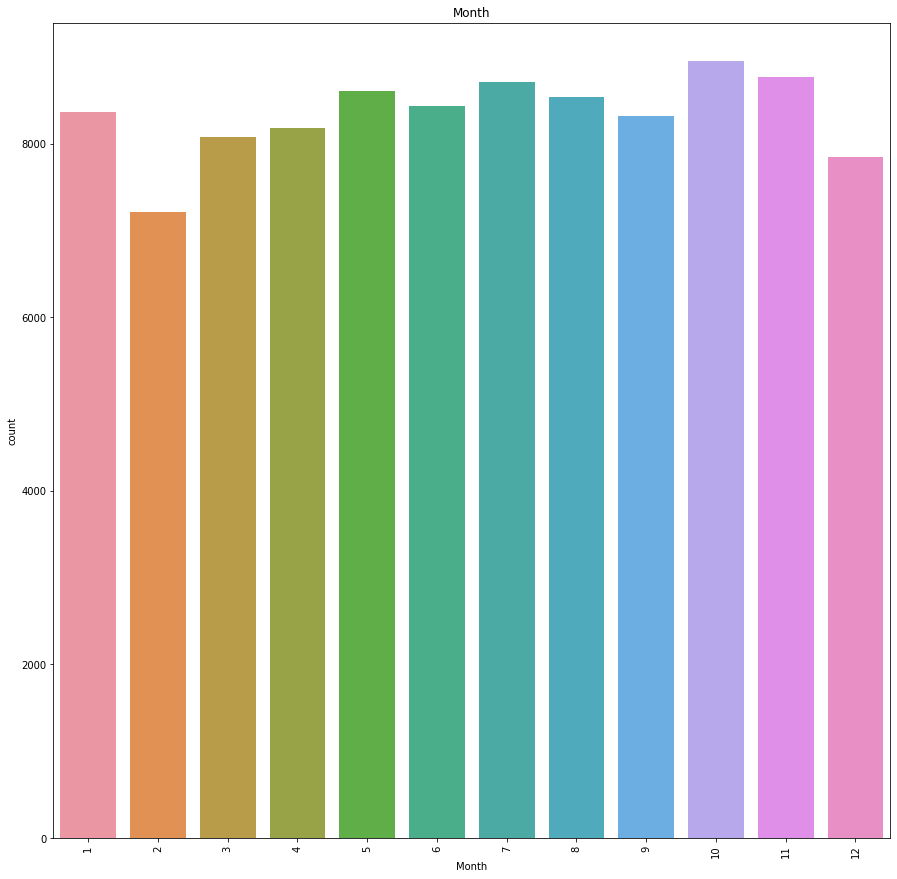

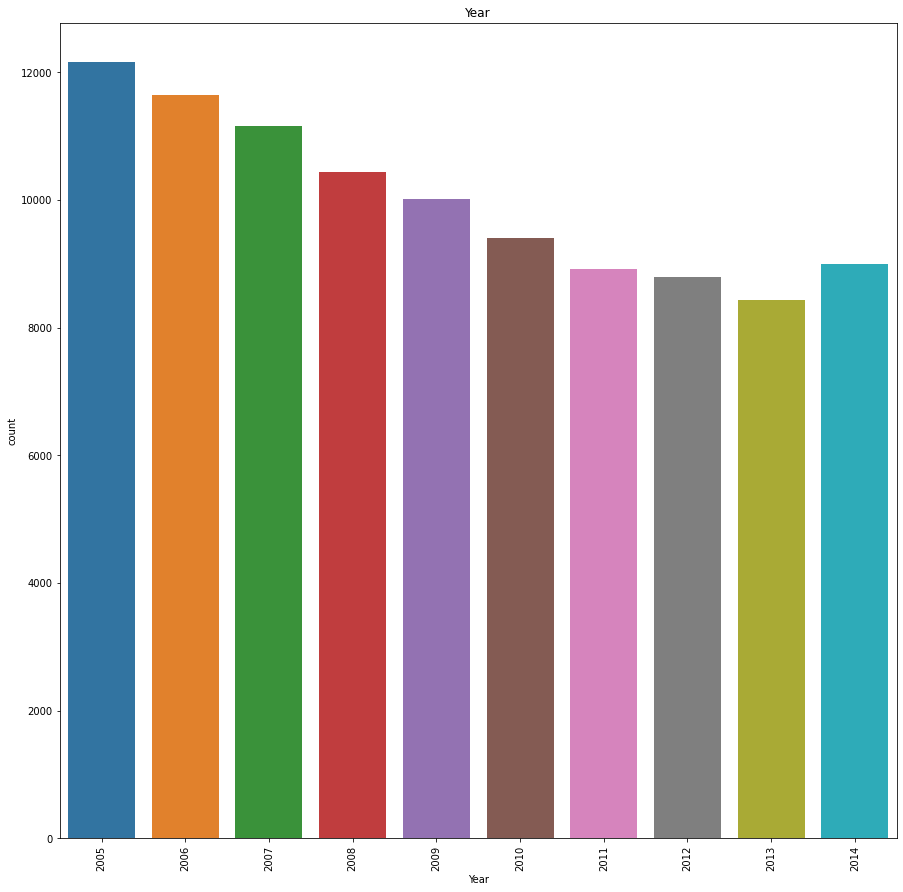

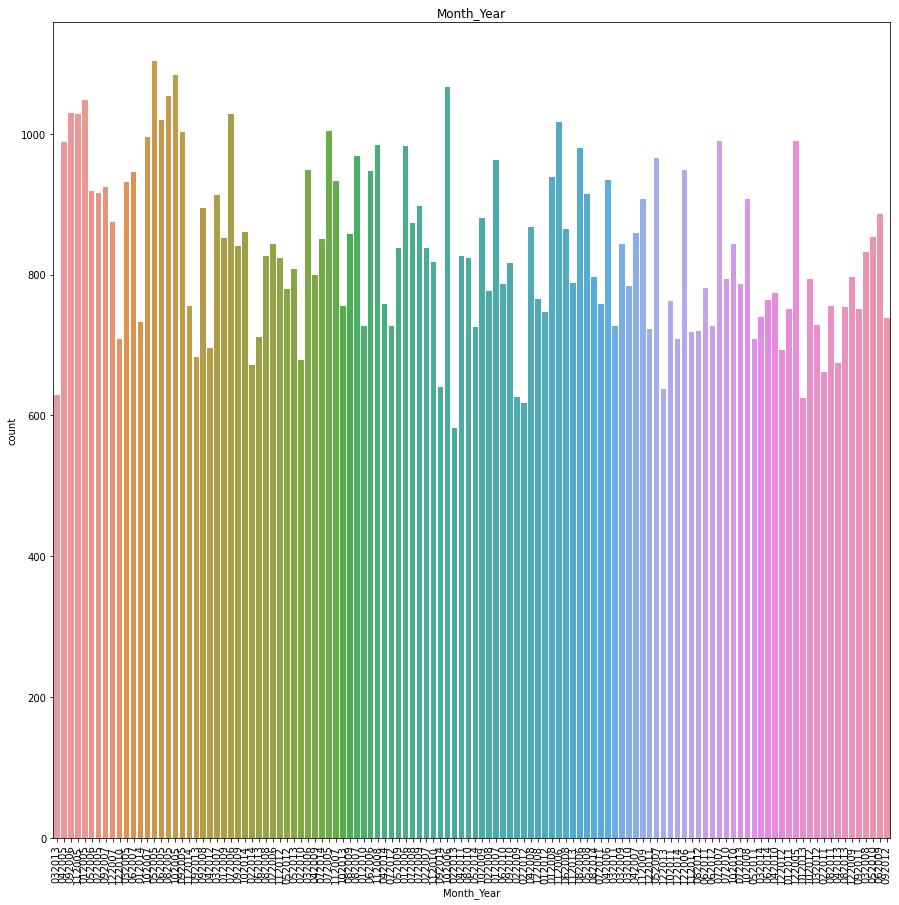

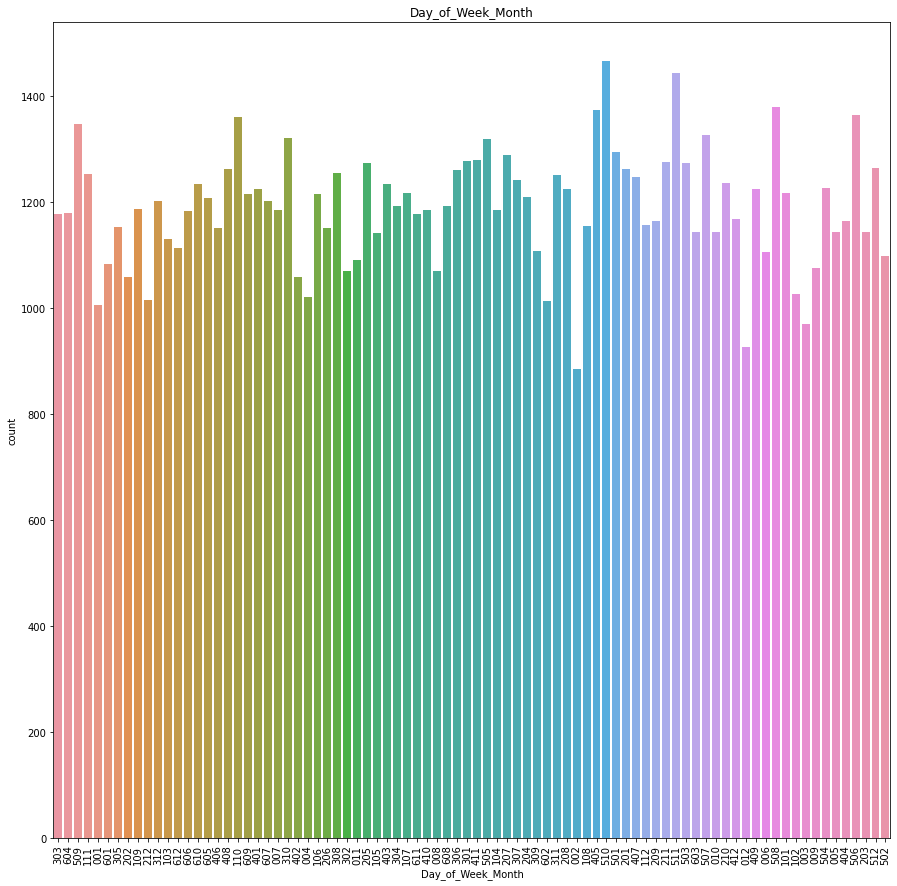

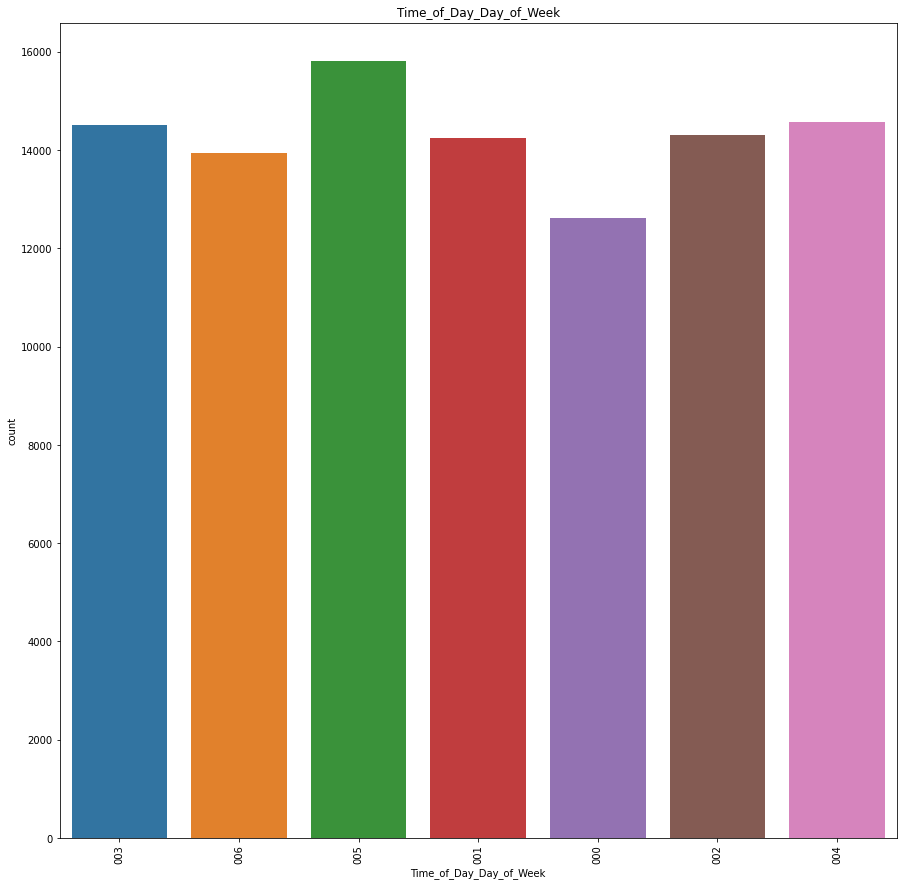

In [22]:
time_features = ['Hour', 'Minute', 'Day_of_Week', 'Month', 'Year', 'Month_Year', 'Day_of_Week_Month', 'Time_of_Day_Day_of_Week']

# subplots of each time feature
for feature in time_features:
    plt.figure(figsize=(15,15))
    sns.countplot(x=feature, data=combined_samples)
    plt.xticks(rotation=90)
    plt.title(feature)
    plt.show()


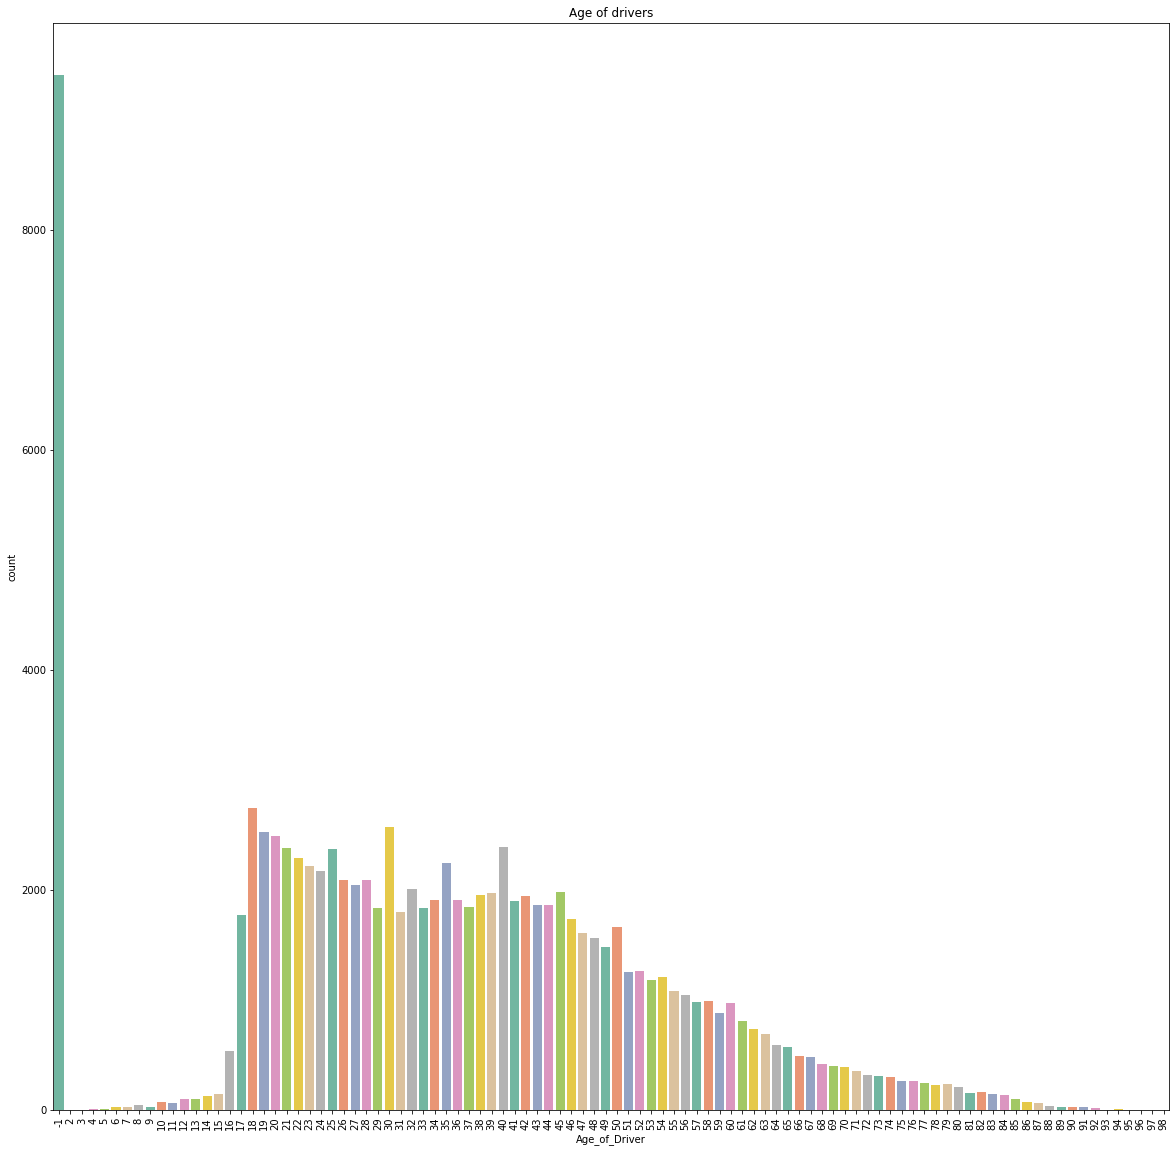

In [23]:
# show age of drivers
plt.figure(figsize=(20,20))
sns.countplot(x='Age_of_Driver', data=combined_samples, palette='Set2')
plt.xticks(rotation=90)
plt.title('Age of drivers')
plt.show()

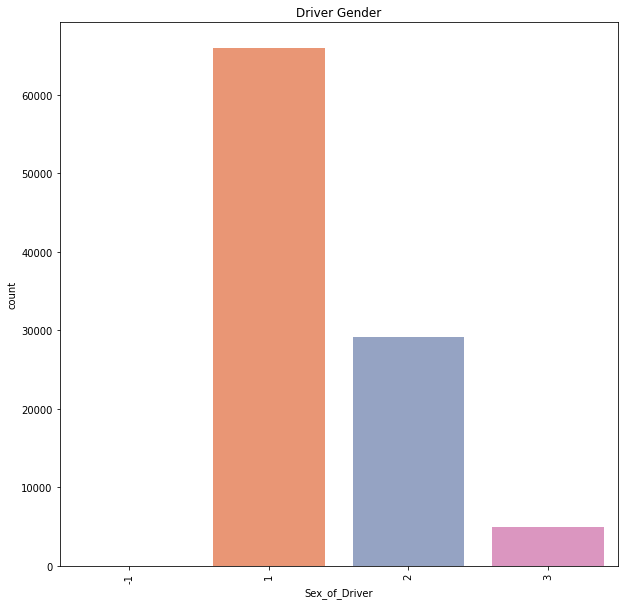

In [24]:
# show age of drivers
# 1 - male, 2 -female, 3 unknown
plt.figure(figsize=(10,10))
sns.countplot(x='Sex_of_Driver', data=combined_samples, palette='Set2')
plt.xticks(rotation=90)
plt.title('Driver Gender')
plt.show()

In [130]:
combined_samples_numeric = combined_samples[['Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week',  
'Local_Authority_(District)',  
'1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',  
'Junction_Detail', 'Junction_Control', '2nd_Road_Class',  
'2nd_Road_Number', 'Light_Conditions',  
'Weather_Conditions', 'Road_Surface_Conditions',  
'Special_Conditions_at_Site', 'Carriageway_Hazards',  
'Urban_or_Rural_Area', 'Casualty_Class', 'Sex_of_Casualty',  
'Age_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity',  
'Pedestrian_Location', 'Pedestrian_Movement', 'Casualty_Type', 'Casualty_Home_Area_Type',  
'Vehicle_Type', 'Junction_Location',  
'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',  
'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',  
'1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',  
'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',  
'Age_Band_of_Driver', 'Age_of_Vehicle', 'Driver_Home_Area_Type']]

KeyError: "['Carriageway_Hazards'] not in index"

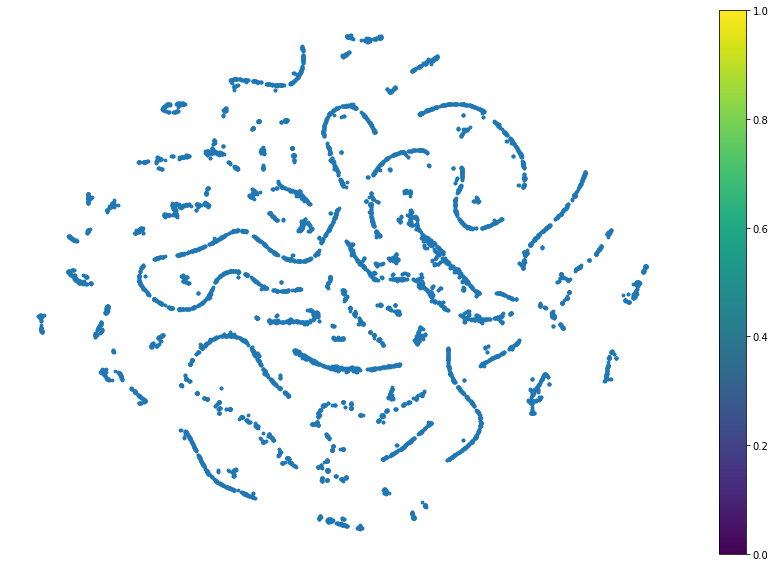

In [69]:
m = 10000
X_reduced = PCA(n_components=0.95).fit_transform(combined_samples_numeric[:10000]) # TODO: use PCA to keep 95% of explained variance in X_viz
viz = TSNE(n_components=2, random_state=42, learning_rate='auto', init='random', n_jobs=-1).fit_transform(X_reduced)
plt.figure(figsize=(15,10))
plt.scatter(viz[:, 0], viz[:, 1], cmap='cool', s=8)
plt.axis('off')
plt.colorbar()